# Hash model
- https://papers.nips.cc/paper/4808-hamming-distance-metric-learning.pdf
- https://arxiv.org/pdf/1702.00758.pdf

In [1]:
# TODO: 
# - Refactor
# - Select from results by model.get_distance(query_img, result_images)
# - add batch normalization https://habrahabr.ru/company/wunderfund/blog/315476/
# - add dropouts
# - remove some maxpool layers

In [2]:
import tensorflow as tf
import numpy as np
from dataset import TripletDataset
from augmentator import Augmentator
from visualisation import show_losses

In [3]:
class HashModel():
    ScopeName = "hashing"
    
    def __init__(self, image_shape, out_dims):
        self.image_shape = image_shape
        self.out_dims    = out_dims
        self._session    = None
        self._graph      = None
        
    def _make_nn(self, images, out_dim, reuse):
        def conv2d_maxpool(inputs, filters, name, reuse, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs      = inputs,
                filters     = filters,
                kernel_size = kernel_size,
                padding     = padding,
                activation  = tf.nn.relu,
                reuse       = reuse,
                name        = name
            )
            l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
            return l
        l = images                                              # 128 x 128 x 1
        l = conv2d_maxpool(l, 16,  reuse=reuse, name='conv1')   #  64 x 64  x 16
        l = conv2d_maxpool(l, 32,  reuse=reuse, name='conv2')   #  32 x 32  x 32
        l = conv2d_maxpool(l, 64,  reuse=reuse, name='conv3')   #  16 x 16  x 64
        l = conv2d_maxpool(l, 128, reuse=reuse, name='conv4')   #   8 x 8   x 128
        l = conv2d_maxpool(l, 256, reuse=reuse, name='conv5')   #   4 x 4   x 256 = 4096
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=2000, activation=tf.nn.relu, reuse=reuse, name='fc1')
        l = tf.layers.dense(l, units=out_dim, reuse=reuse, name='logits')
        l = tf.nn.tanh(l*self.b_pl)
        return l

    def _make_loss(self, main, same, diff, margin):
        K = self.out_dims
        def hamming_distance(a, b):
            prod = tf.reduce_sum(tf.multiply(a, b), axis=1)
            dist = (K - prod)/2
            return dist
        
        dist = hamming_distance
        pos_dist = dist(main, same)
        neg_dist = dist(main, diff)
        loss = tf.nn.relu(pos_dist - neg_dist + margin)
        loss = tf.reduce_mean(loss)
        return loss

    def build(self):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        img_shape = self.image_shape
        with self._graph.as_default(), tf.name_scope(self.ScopeName), tf.device('/gpu:0'):
            # placeholders
            self.img_main_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='main_img')
            self.img_same_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='same_img')
            self.img_diff_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='diff_img')
            self.margin_pl   = tf.placeholder(dtype=tf.float32, name='margin')
            self.b_pl        = tf.placeholder(dtype=tf.float32, name='b')
            self.lr_pl       = tf.placeholder(dtype=tf.float32, name='lr')
            # network
            self.nn_main   = self._make_nn(self.img_main_pl, self.out_dims, reuse=False)
            self.nn_same   = self._make_nn(self.img_same_pl, self.out_dims, reuse=True)
            self.nn_diff   = self._make_nn(self.img_diff_pl, self.out_dims, reuse=True)
            # operations
            self.loss_op   = self._make_loss(self.nn_main, self.nn_same, self.nn_diff, self.margin_pl)
            self.train_op  = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op   = tf.global_variables_initializer()
            
        self._session = tf.Session(graph=self._graph)
        self._session.run(self.init_op)
        
    def train(self, dataset, step_num, batch_size, margin, b, lr, aug, log_every=10, mean_win=100):
        try:
            losses = []
            for step in range(step_num):
                img_main, img_same, img_diff = dataset.get_next_batch(batch_size)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.img_main_pl: aug(img_main),
                    self.img_same_pl: aug(img_same),
                    self.img_diff_pl: aug(img_diff),
                    self.margin_pl:   margin,
                    self.b_pl:        b,
                    self.lr_pl:       lr,
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, mean_win)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, mean_win)

    def save(self, path):
        with self._graph.as_default(), tf.name_scope(self.ScopeName):
            saver = tf.train.Saver()
        saver.save(self._session, path)
        
    def restore(self, path):
        with self._graph.as_default(), tf.name_scope(self.ScopeName):
            saver = tf.train.Saver()
        saver.restore(self._session, path)        
    
    def run(self, imgs, batch_size=100, b=100):
        outputs = np.zeros(shape=[len(imgs), self.out_dims])
        bs = min(len(imgs), batch_size)
        for i in range(len(imgs)//bs):
            batch = imgs[i*bs:(i+1)*bs,:]
            outputs[i*bs:(i+1)*bs,:] = self._session.run(self.nn_main, feed_dict = {
                self.img_main_pl : batch,
                self.b_pl : b,
            })
        return outputs

## Create model

In [4]:
data_size   = 100
image_shape = [128,128,1]
out_dims    = 64

dataset     = TripletDataset(image_shape)
dataset.load("/netforge/datasets/private/roman/coins/images", data_size)

In [5]:
%%time
model = HashModel(image_shape, out_dims)
model.build()

CPU times: user 12.9 s, sys: 484 ms, total: 13.4 s
Wall time: 13.4 s


## Train model

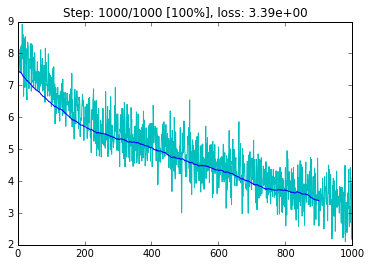

CPU times: user 4min 10s, sys: 38.8 s, total: 4min 48s
Wall time: 4min 26s


In [6]:
%%time
tr_aug = Augmentator(
    cache_size = 100, 
    rate       = 1)

model.train(
    dataset    = dataset,
    aug        = tr_aug.augment,
    step_num   = 1000, 
    batch_size = 64, 
    b          = 1e2, 
    lr         = 1e-5, 
    margin     = 8)
model.save("data/hash_model/001/")

## Test quality

## Test quality

In [16]:
from sklearn.neighbors import BallTree

class DataBase:
    def _get_codes(self, images):
        outputs = self.model.run(images)
        codes  = np.sign((hashes+1)/2)
        return codes
        
    def build(self, model, images):
        self.model      = model
        self.images     = np.copy(images)
        self.bin_codes  = self._get_codes(images)
        self.ball_tree  = BallTree(self.bin_codes, metric = 'hamming')
        
    def query(self, images, k=1):
        codes  = self._get_codes(images)
        dist, ind = self.ball_tree.query(codes, k)
        return ind, dist

In [17]:
images   = dataset.test_images[:1000]
database = DataBase()
database.build(model, images)

## Restore model

In [15]:
_hash_model.restore("data/hash_model/001/")

INFO:tensorflow:Restoring parameters from data/hash_model/001/
